In [2]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
import sys
import os
from datasets import get_dataloaders
from models import get_model
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

In [21]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader


transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

train_dataset = CIFAR100(root="./data", train=True, download=True)
test_dataset = CIFAR100(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [38]:
train_dataset.data[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [195, 205, 193],
        [212, 224, 204],
        [182, 194, 167]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [170, 176, 150],
        [161, 168, 130],
        [146, 154, 113]],

       [[255, 255, 255],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [189, 199, 169],
        [166, 178, 130],
        [121, 133,  87]],

       ...,

       [[148, 185,  79],
        [142, 182,  57],
        [140, 179,  60],
        ...,
        [ 30,  17,   1],
        [ 65,  62,  15],
        [ 76,  77,  20]],

       [[122, 157,  66],
        [120, 155,  58],
        [126, 160,  71],
        ...,
        [ 22,  16,   3],
        [ 97, 112,  56],
        [141, 161,  87]],

       [[ 87, 122,  41],
        [ 88, 122,  39],
        [101, 134,  56],
        ...,
        [ 34,  36,  10],
        [105, 133,  59],
        [138, 173,  79]]

In [37]:
train_dataset.targets[0]

19

In [41]:
train_dataset.class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

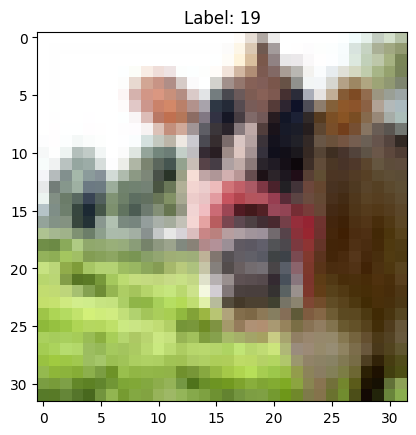

In [39]:
plt.title(f"Label: {train_dataset.targets[0]}")
plt.imshow(train_dataset.data[0])
plt.show()

In [28]:
image = train_dataset.data[0][1]
label = train_dataset.data[1][2]
label

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [254, 254, 254],
       [253, 253, 254],
       [254, 255, 255],
       [253, 254, 254],
       [255, 255, 255],
       [223, 221, 213],
       [215, 213, 207],
       [255, 255, 255],
       [254, 254, 254],
       [254, 254, 254],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [8]:
data = next(iter(train_loader))
data

[tensor([[[[-1.8971e+00, -1.8971e+00, -1.8971e+00,  ..., -1.7798e+00,
            -1.7798e+00, -1.7651e+00],
           [-1.8971e+00, -1.8824e+00, -1.8971e+00,  ..., -1.7944e+00,
            -1.7651e+00, -1.7357e+00],
           [-1.8824e+00, -1.8824e+00, -1.8824e+00,  ..., -1.8091e+00,
            -1.8091e+00, -1.7357e+00],
           ...,
           [-8.9949e-01, -8.4080e-01, -7.3811e-01,  ..., -8.9949e-01,
            -8.8482e-01, -4.8870e-01],
           [-9.1416e-01, -8.8482e-01, -7.9679e-01,  ..., -7.3811e-01,
            -9.1416e-01, -1.0609e+00],
           [-6.7942e-01, -7.9679e-01, -1.0022e+00,  ..., -7.5278e-01,
            -8.7015e-01, -8.1146e-01]],
 
          [[-1.8974e+00, -1.8974e+00, -1.8974e+00,  ..., -1.7139e+00,
            -1.6833e+00, -1.6068e+00],
           [-1.8974e+00, -1.8821e+00, -1.8974e+00,  ..., -1.7292e+00,
            -1.6833e+00, -1.5151e+00],
           [-1.8821e+00, -1.8821e+00, -1.8821e+00,  ..., -1.7292e+00,
            -1.7598e+00, -1.5762e+00],


In [13]:
image = data[0][1]
label = data[1][2]

In [20]:
image = data[0][1]
image

tensor([[[1.6826, 1.6239, 1.6093,  ..., 1.5652, 1.5359, 1.5212],
         [1.6679, 1.6386, 1.6093,  ..., 1.5652, 1.5506, 1.5212],
         [1.6826, 1.6826, 1.6679,  ..., 1.6093, 1.5946, 1.5799],
         ...,
         [1.7560, 1.6826, 1.6093,  ..., 1.3892, 1.3892, 1.3599],
         [1.7706, 1.6533, 1.6093,  ..., 1.3892, 1.3892, 1.3599],
         [1.7853, 1.6826, 1.6093,  ..., 1.3892, 1.3892, 1.3599]],

        [[1.9110, 1.8498, 1.8345,  ..., 1.6815, 1.6662, 1.6662],
         [1.8957, 1.8651, 1.8345,  ..., 1.6968, 1.6815, 1.6662],
         [1.9110, 1.9110, 1.8957,  ..., 1.7580, 1.7427, 1.7427],
         ...,
         [1.8804, 1.8039, 1.7274,  ..., 1.4980, 1.4980, 1.4827],
         [1.8957, 1.7733, 1.7427,  ..., 1.4980, 1.4980, 1.4827],
         [1.9110, 1.8039, 1.7427,  ..., 1.4980, 1.4980, 1.4827]],

        [[1.9817, 1.9249, 1.9107,  ..., 1.4989, 1.4847, 1.4705],
         [1.9675, 1.9249, 1.9107,  ..., 1.5983, 1.5841, 1.5699],
         [1.9817, 1.9817, 1.9675,  ..., 1.7119, 1.6977, 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8295992..2.0100594].


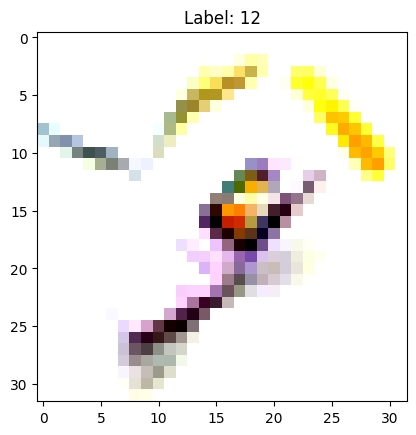

In [18]:
plt.title(f"Label: {label}")
plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()